# Optional: 3D Image Filters
Image segmentation in 3D is challenging for several reasons. One typical problem is anisotropy, where voxel x and y sizes are not the same as their z size. Depending on the applied algorithms and respective given parameters, this may be a problem. Some algorithms only work for isotropic data.

In [1]:
from skimage.io import imread
from skimage import filters
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics
# processing units might be necessary
import pyclesperanto_prototype as cle

To demonstrate the workflow, we're using cropped and resampled image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

In [2]:
image = imread("../../data/BMP4blastocystC3-cropped_resampled_8bit_2nuclei.tif")

voxel_size_x = 0.202 # um
voxel_size_y = 0.202 # um
voxel_size_z = 1 # um

Let's check its shape.

In [3]:
print('pixels (z, y, x) = ', image.shape)

pixels (z, y, x) =  (32, 61, 74)


## Displaying anisotropic images in napari

In [4]:
viewer = napari.Viewer()

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded


In [5]:
viewer.add_image(image)
# Turns on 3D visualization
viewer.dims.ndisplay = 3

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


If we rotate a view a bit in napari, we can see two nuclei. It also looks that the image is a bit squashed. 

That's because napari received  raw image as a layer. Without any voxel size information, it assumes they are isotropic and this is the effect.

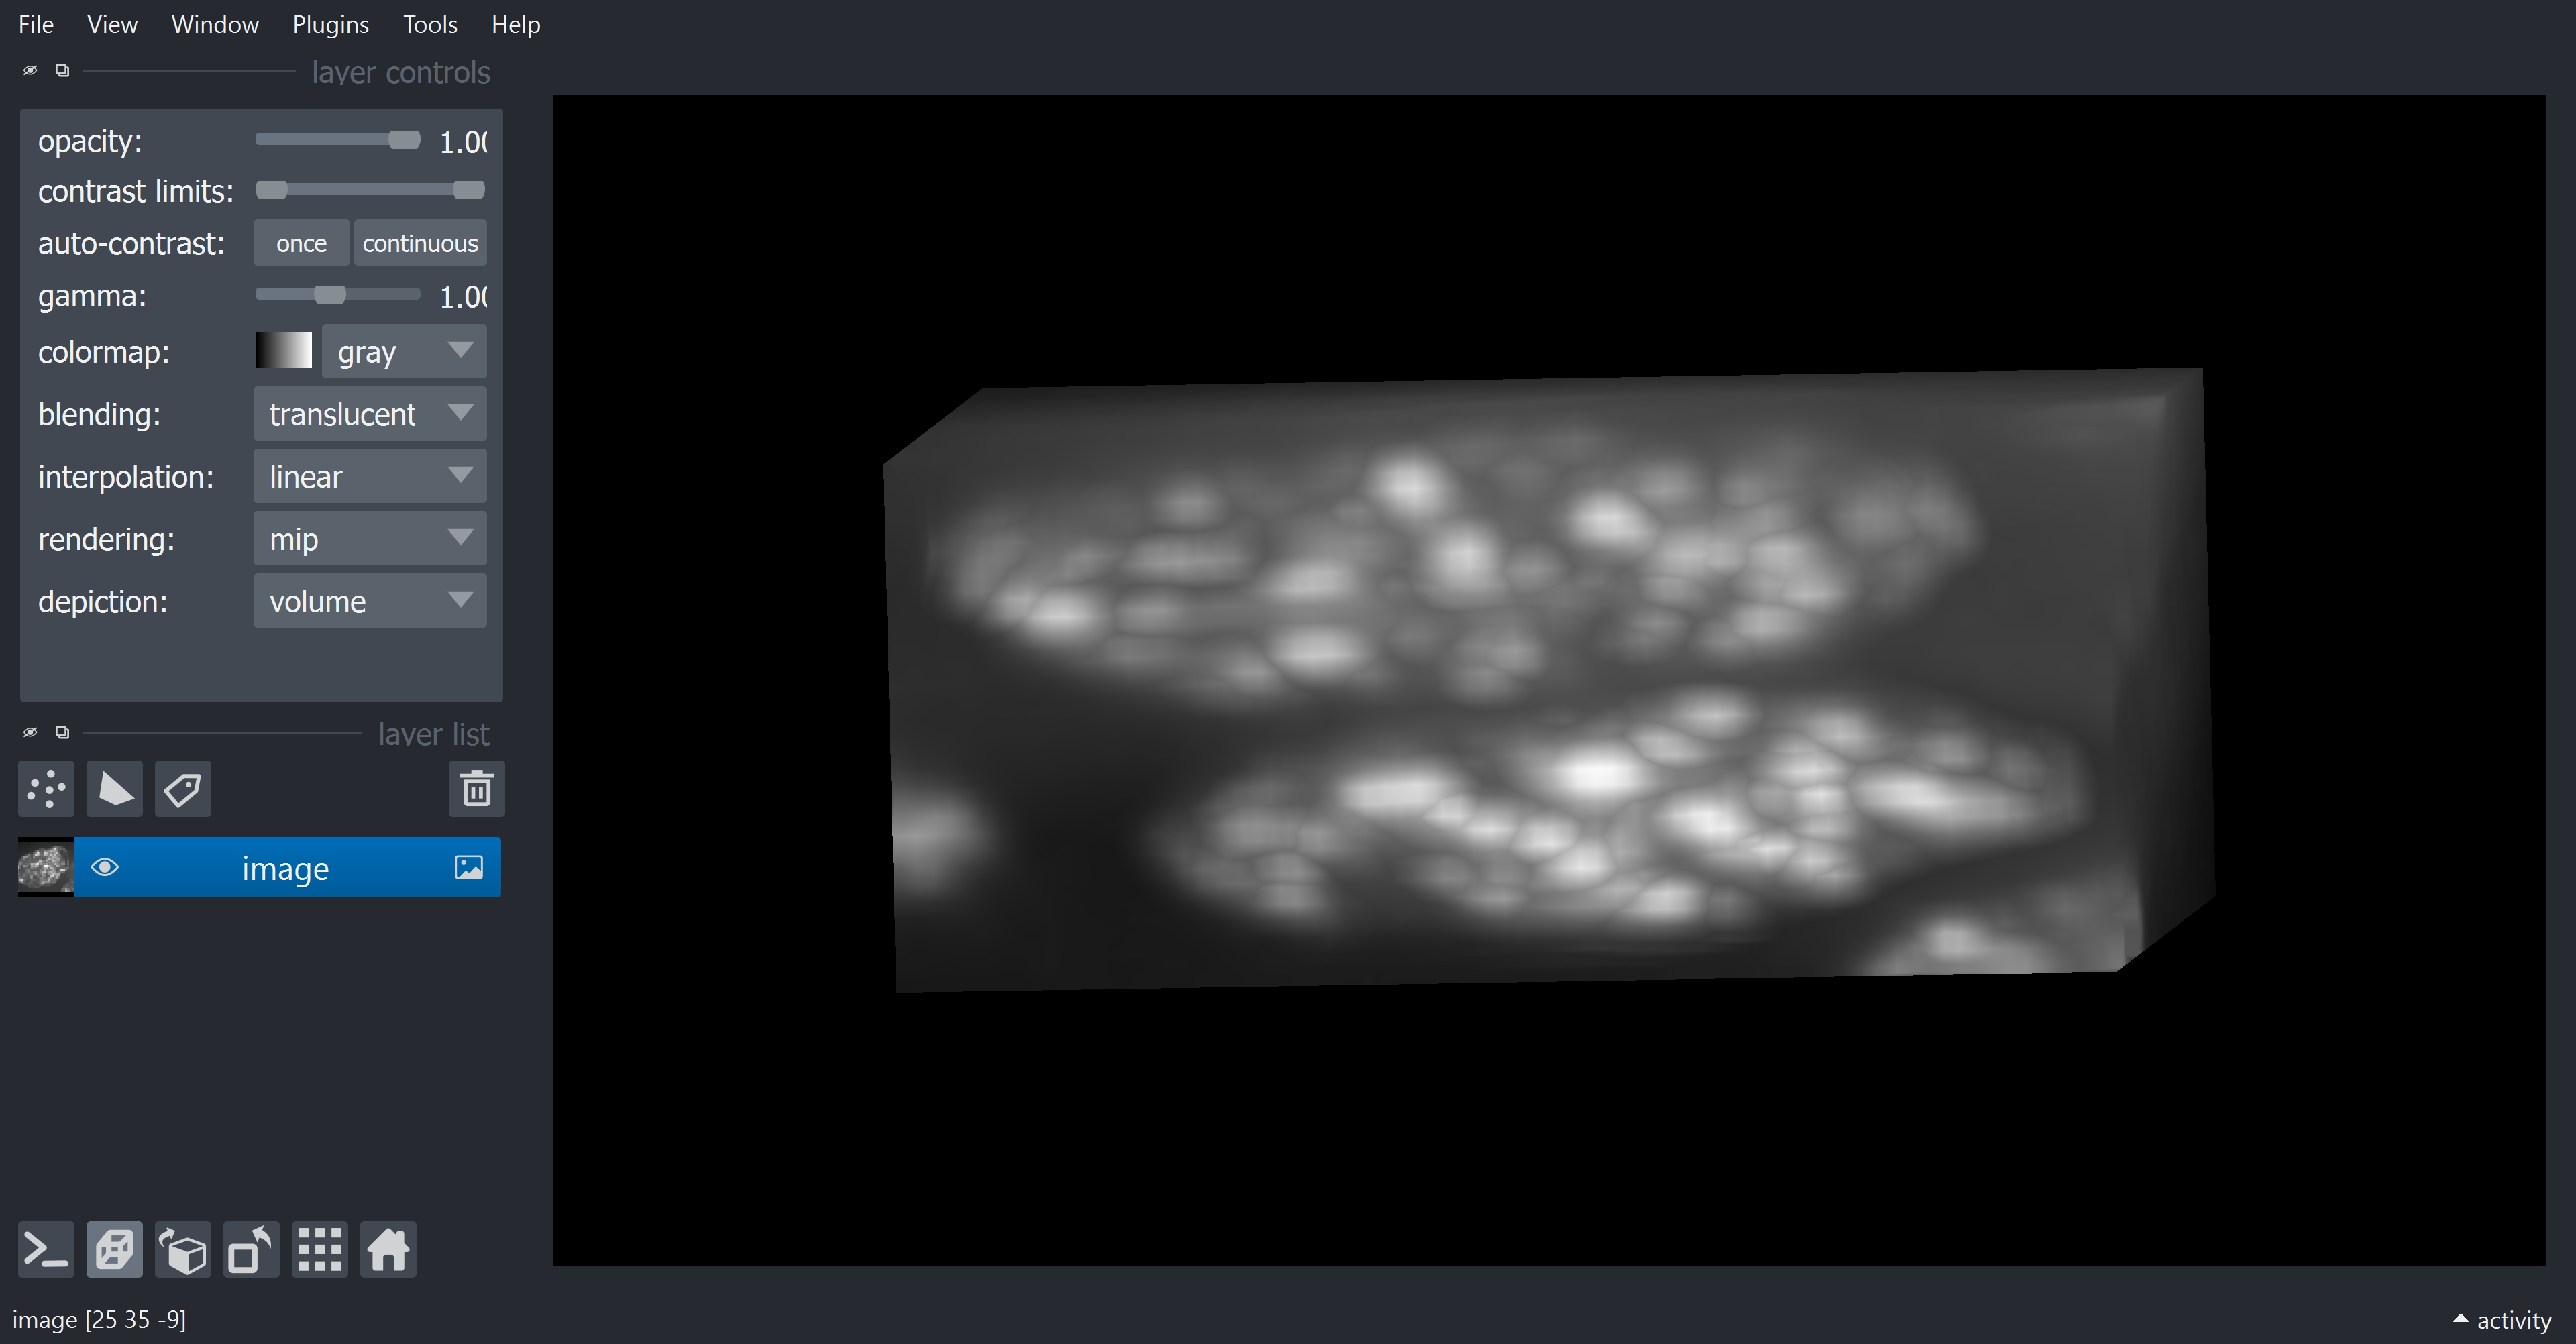

In [6]:
nbscreenshot(viewer)

We would have to re-scale in each dimension to fix that. This can be done by calculating a ratio of sizes. Let's use the x voxel size as a reference and calculate scaling fators for each dimension.

In [7]:
reference_size = voxel_size_x

factor_z = voxel_size_z / reference_size
factor_y = voxel_size_y / reference_size
factor_x = voxel_size_x / reference_size

print(factor_z, factor_y, factor_x)

4.9504950495049505 1.0 1.0


We can provide these factors to napari as a scaling factor. This way, napari can display the image as it is physically supposed toi be.
We can do that by means of the `scale` property of the layer.

In [8]:
viewer.layers['image'].scale = [factor_z, factor_y, factor_x] # Z, Y, X order

Now, if we unzoom a bit your image in napari, it should look correct.

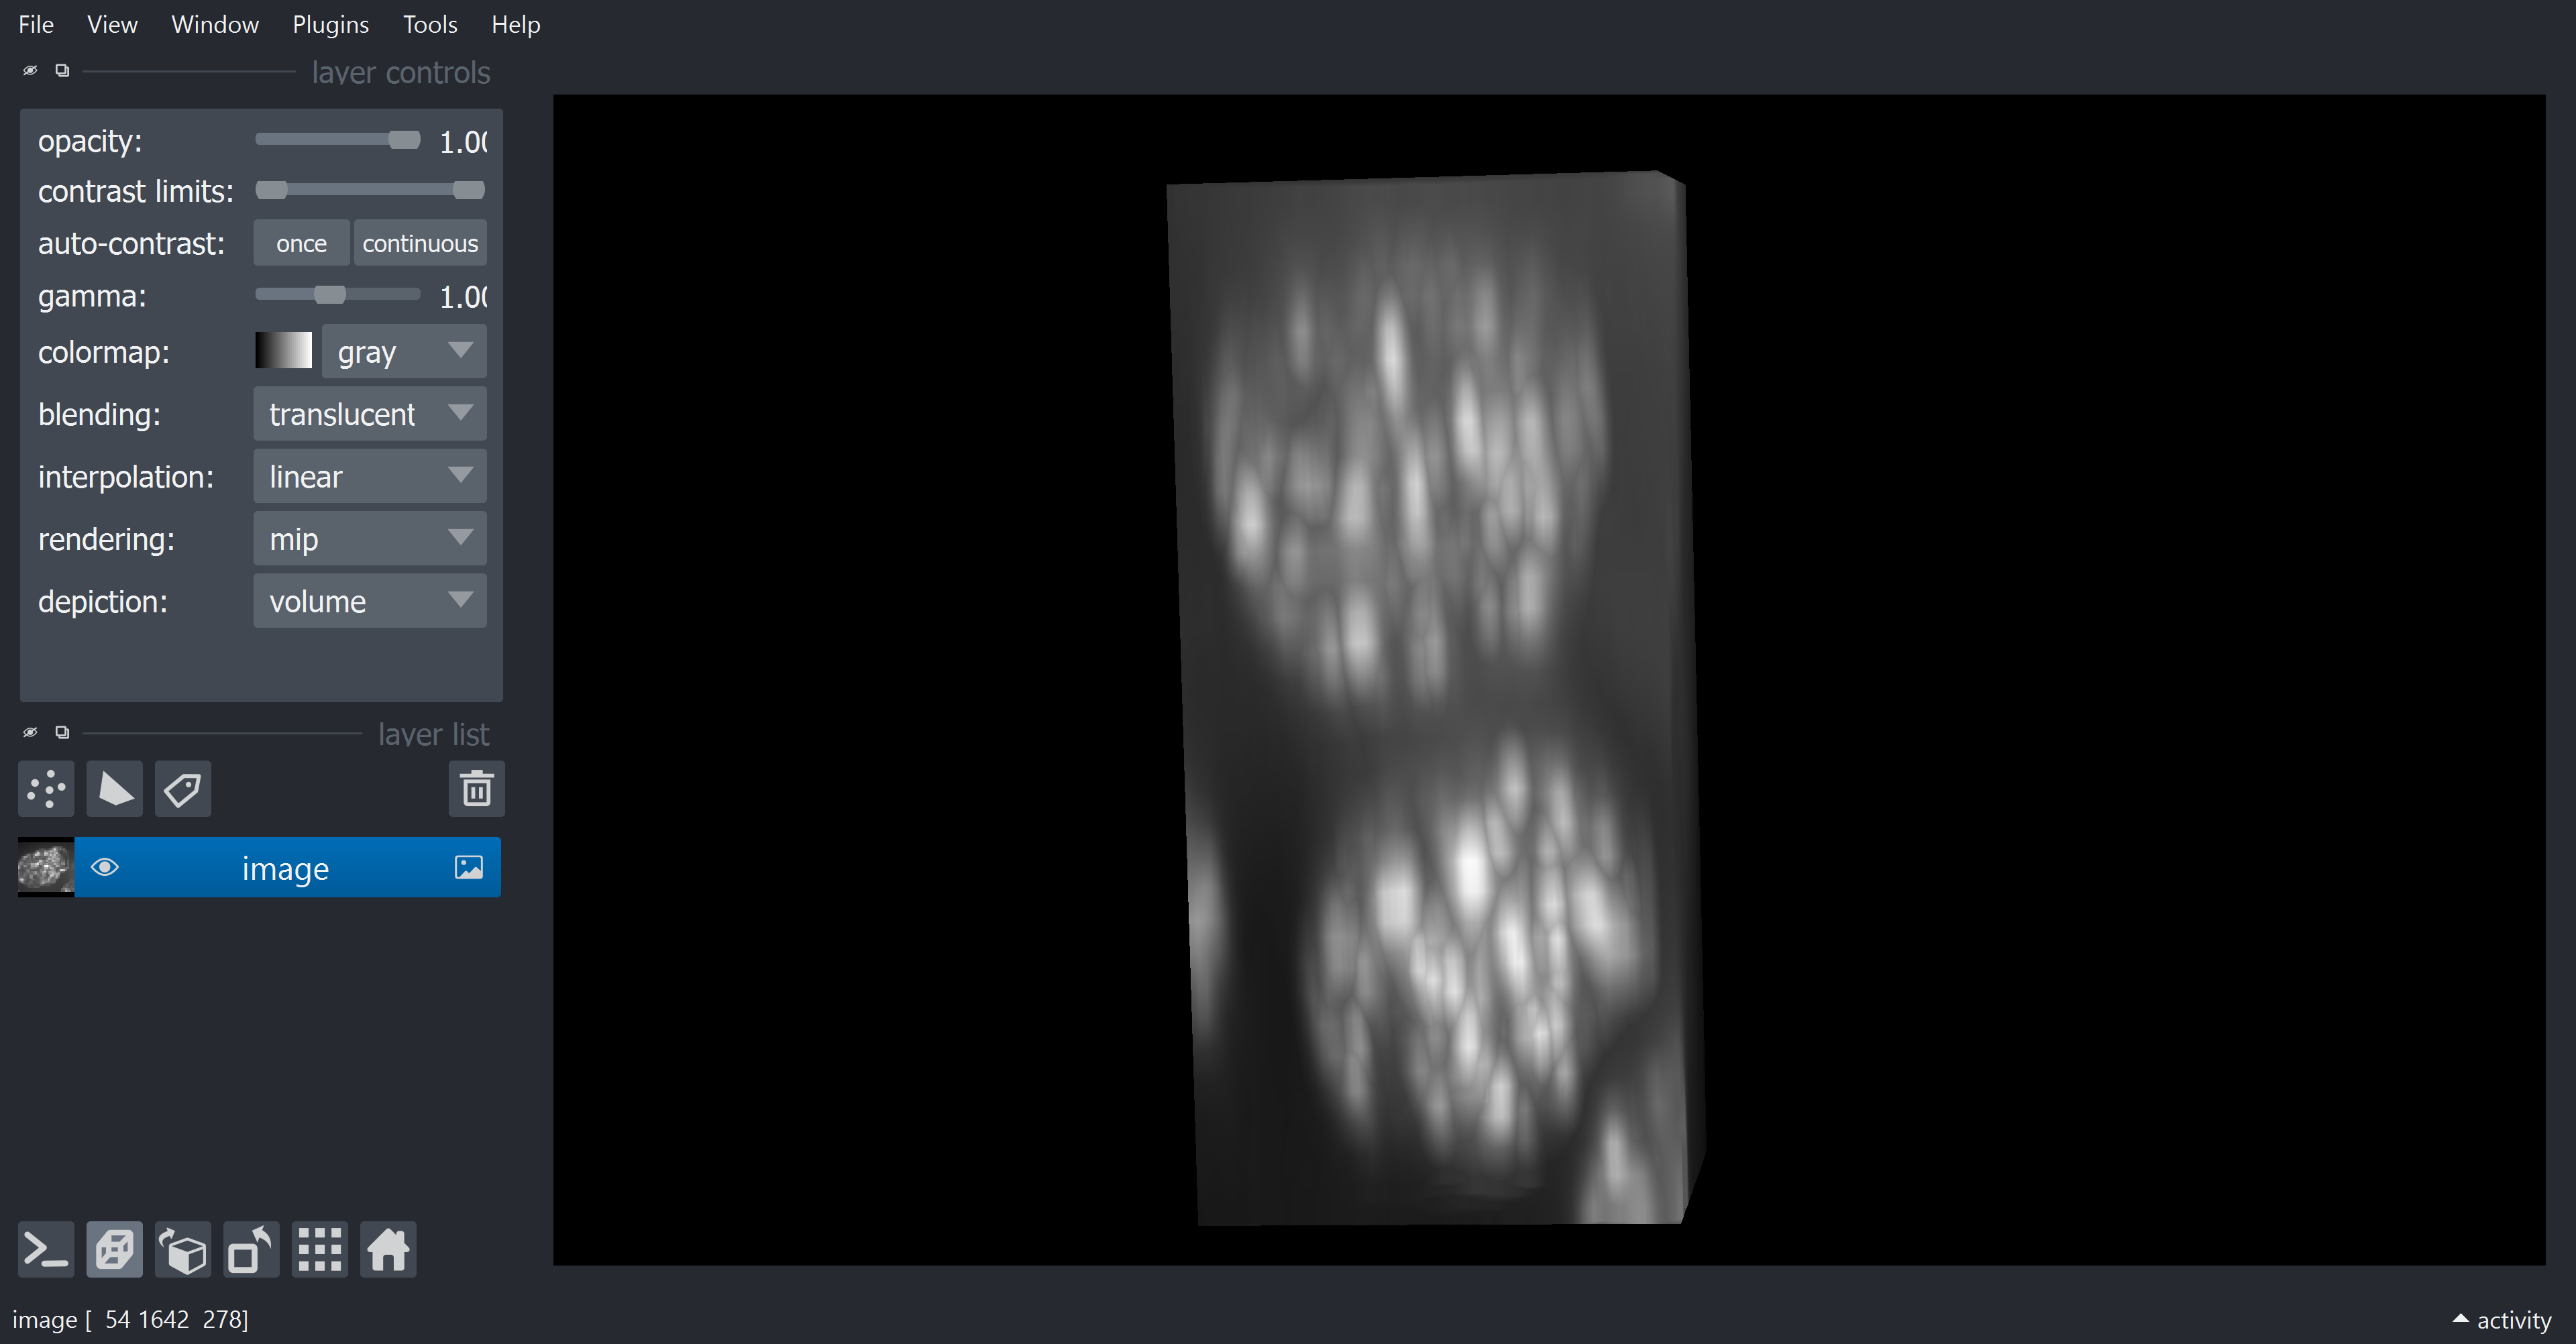

In [9]:
nbscreenshot(viewer)

## Filtering in 3D

Filters in 3D typically involve the same functions. Let's apply a gaussin blur to this image, add the output to napari (with proper scaling) and check the results.  For GPU acceleration, use `cle.gaussian_blur` from [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) instead.

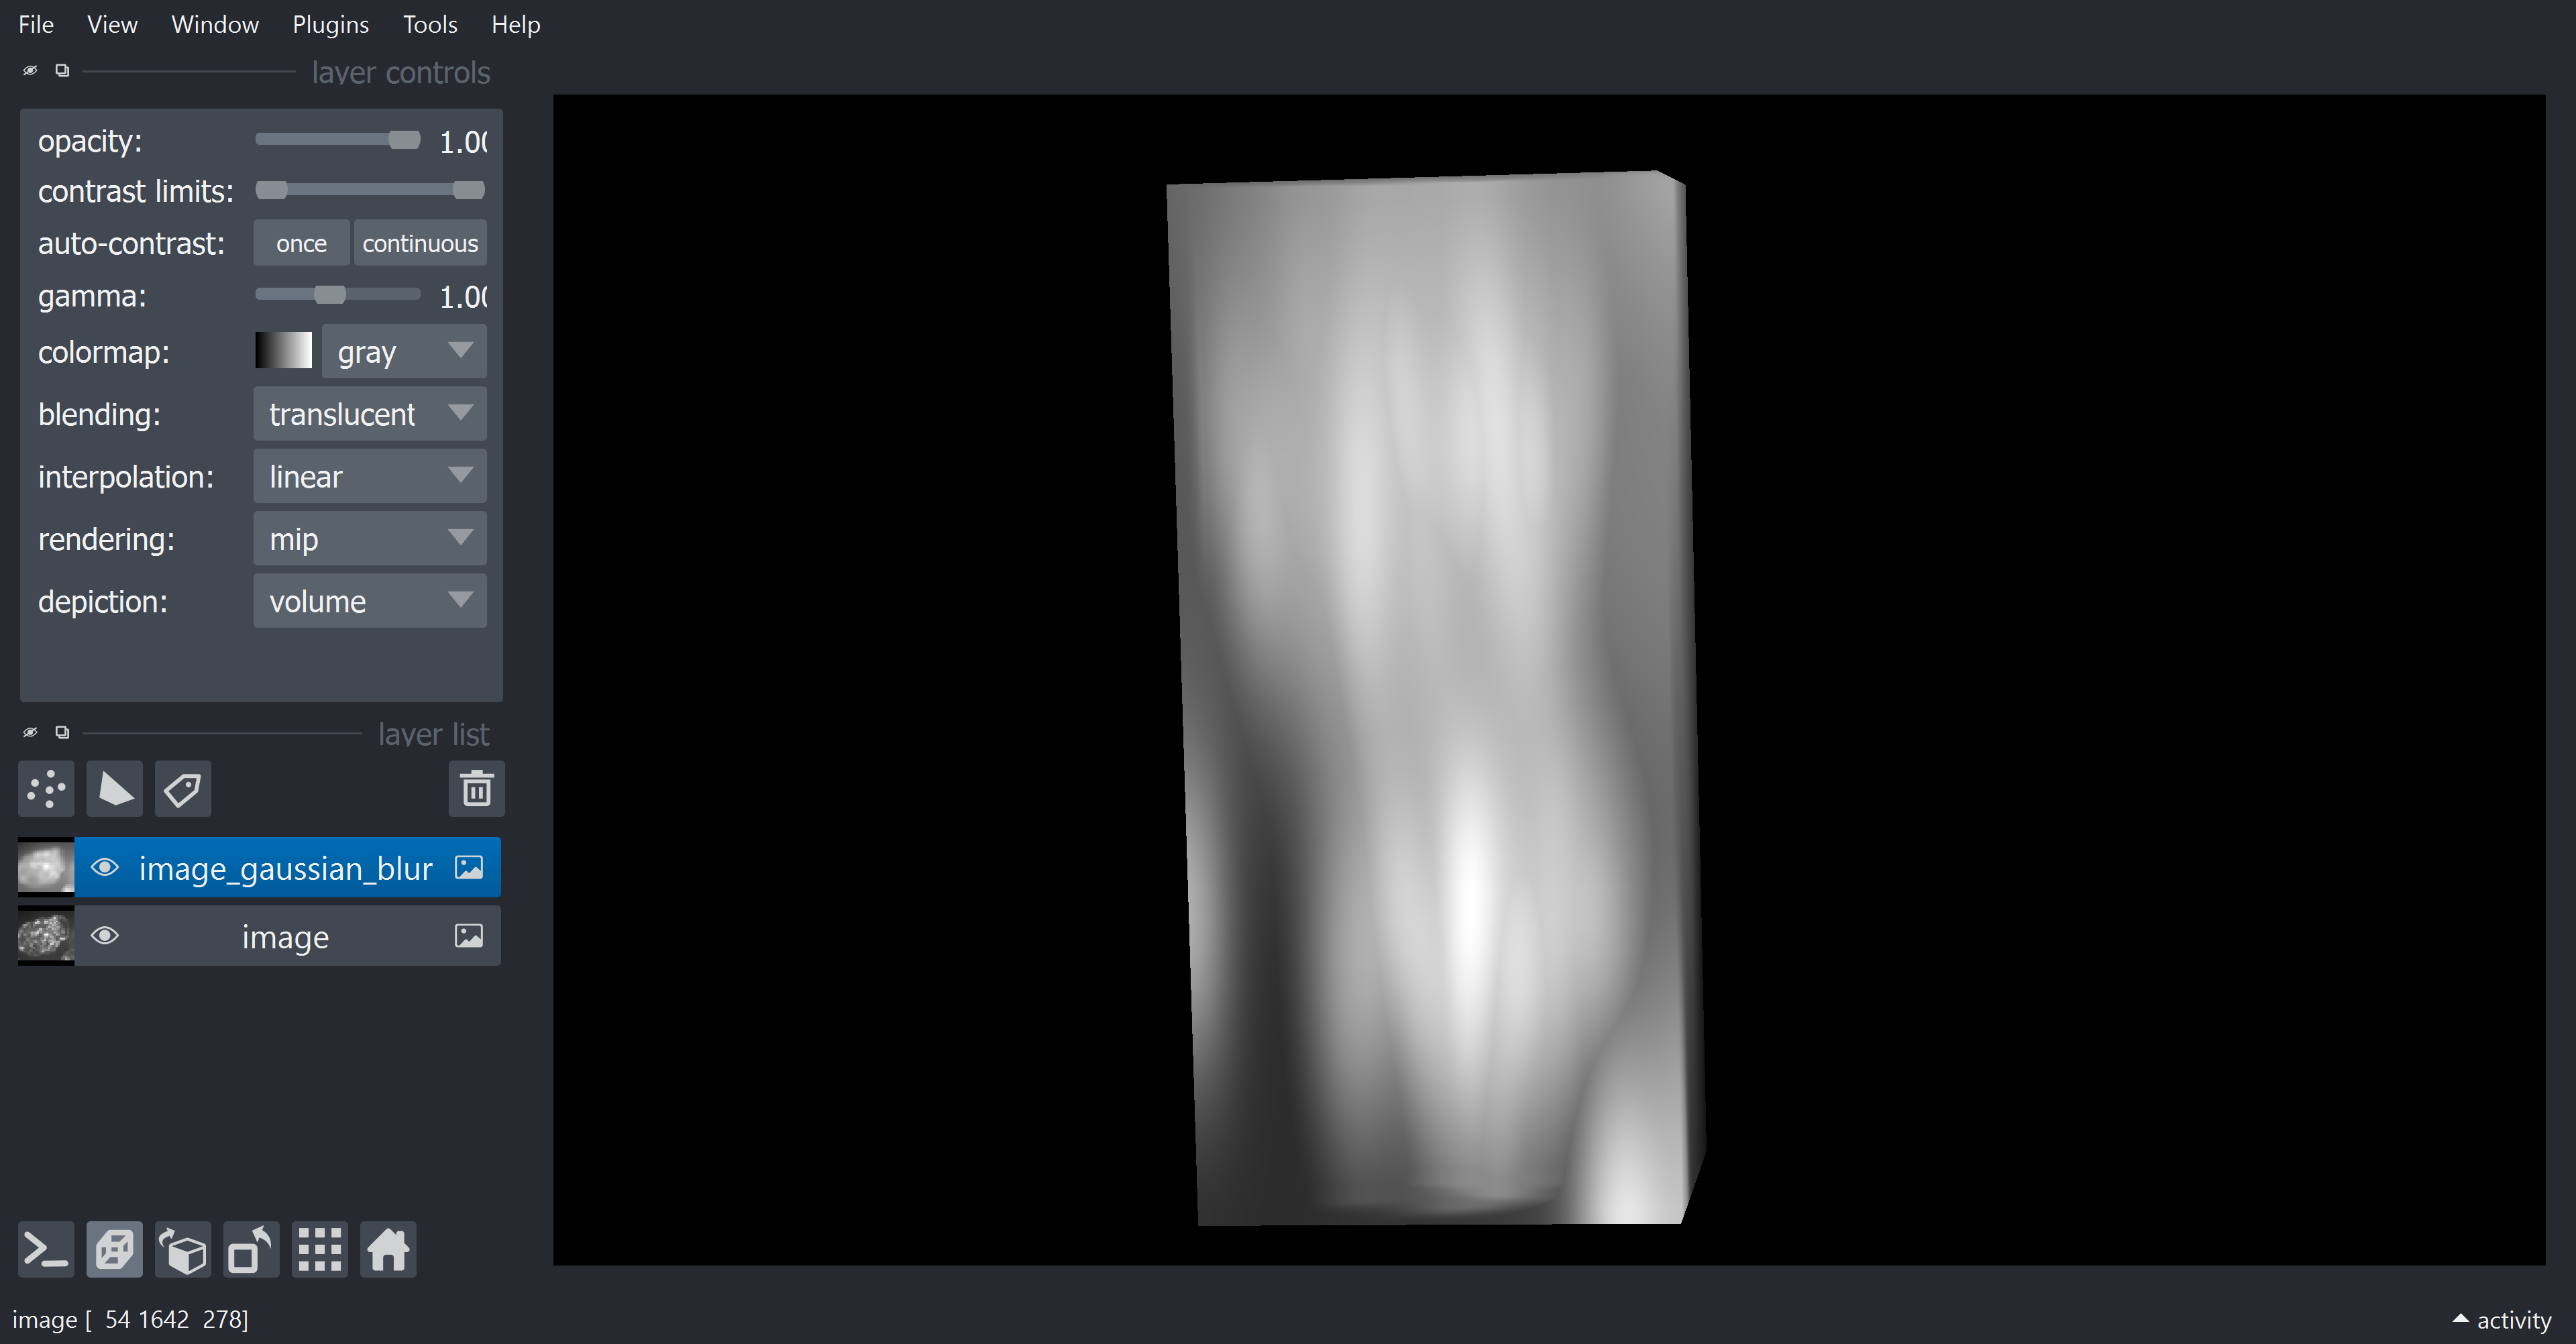

In [10]:
image_gaussian_blur = filters.gaussian(image, sigma = 3)
viewer.add_image(image_gaussian_blur, name = 'image_gaussian_blur', scale = [factor_z, factor_y, factor_x])
nbscreenshot(viewer)

It seems it blured a lot more than expected. That's because many image processing functions that use convolution, like filters, do not account for different voxel sizes.

Also, the `scale` property in napari is used just for visualization, we did not actually change our image shape.

In [11]:
image_from_layer = viewer.layers['image'].data
print('pixels (z, y, x) = ', image_from_layer.shape)

pixels (z, y, x) =  (32, 61, 74)


In order to make these 3D operations work properly, it is important to actually transform the data and make the image isotropic.

*Note: always read the function documentation that you are about to use. There may be implementations where anisotropy may be already taken into account by providing voxel sizes as arguments.*

## Making data isotropic

To make an anisotopic image isotropic, we need to rescale it. We will use the [rescale](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rescale) from scikit-image. For GPU acceleration, use `cle.scale` from [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) instead.

In [12]:
from skimage.transform import rescale

In [13]:
image_rescaled = rescale(image, [factor_z, factor_y, factor_x])

We can see that we actually changed the image shape now.

In [14]:
print('pixels (z, y, x) = ', image_rescaled.shape)

pixels (z, y, x) =  (158, 61, 74)


Also, in napari, it already has the right display scale, no need to handle the `scale` property now.

In [15]:
viewer.add_image(image_rescaled, name = 'image_rescaled')

<Image layer 'image_rescaled' at 0x14681070ac0>

## Filtering in 3D with isotropic images

Let's apply the same filter to the rescaled image and add the results to napari to compare.

In [16]:
image_rescaled_gaussian_blur = filters.gaussian(image_rescaled, sigma = 3)
viewer.add_image(image_rescaled_gaussian_blur, name = 'rescaled_gaussian_blur_3')

<Image layer 'rescaled_gaussian_blur_3' at 0x146802397c0>

Now with the grid mode, we can clearly see that the results are different. The image got much less blured in z.

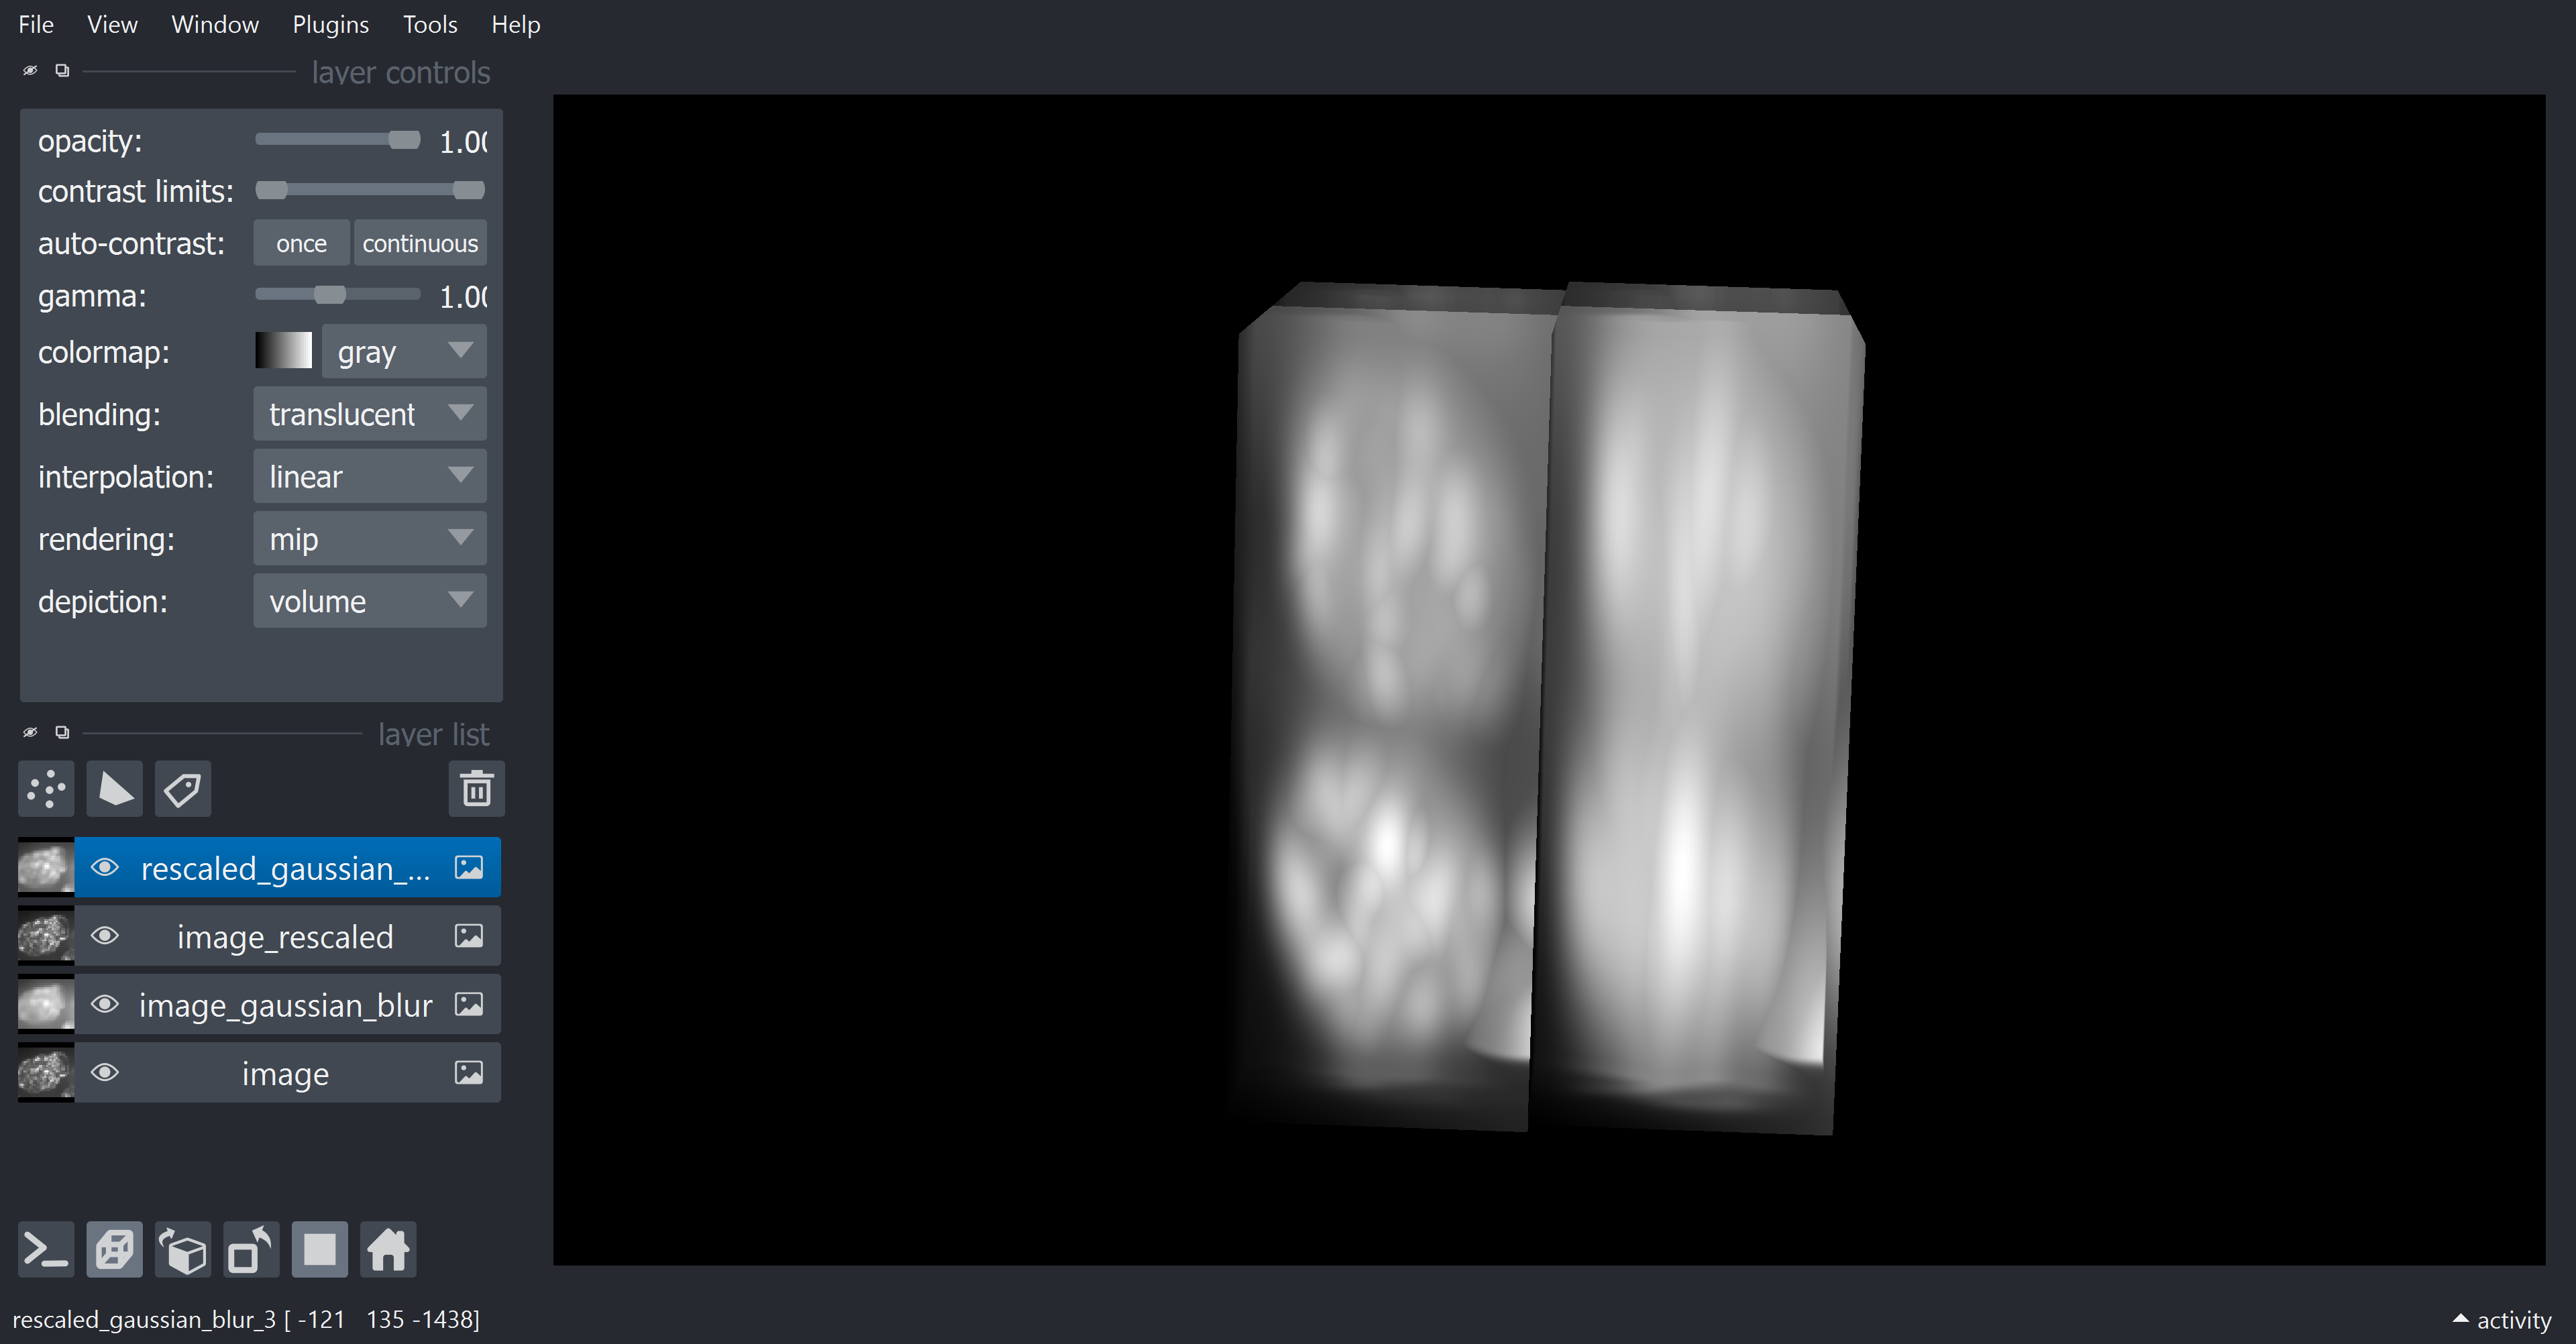

In [18]:
# turn grid mode on
viewer.grid.enabled = True
nbscreenshot(viewer)

# Exercise

The way we rescaled here, we actually increased the image size with interpolation. If images are very big, it may be advantageous to downsample in x and y instead of upsampling in z.

Calculate new scale factors and rescale the image to become smaller instead of bigger. Then apply a gaussian filter with `sigma = 1` and display the results in napari.

By looking at the scaling factors, how do you know if the output image will be smaller or bigger?